# PHYS 142 Final Project (Prompt #2)
# Spr '22
## Group members:
### Christian Amezcua, Kentaro Hanson, Anastasia Ordonez

*Consider the double-well oscillator for quantum mechanical electron*

*(a) Evaluate the ground state energy $E_0$ from the Metropolis Monte Carlo path integral approximation for sufficiently large $\tau$ so that $E_0$ dominates*

*(b) Plot the ground state probability distribution*

In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs # python adaptation of ARPACK
from scipy.sparse import spdiags

In [3]:
#set up parameters for double well potential
k = 2
alpha = 0.4

m = 1
hbar = 1
omega = 1
xmin = 1 / np.sqrt(alpha) # absolute value of potential well minima
#barrier = 1 / alpha # potential barrier height (unsure if necessary)

#sampling parameters
n_d = 600 # spatial resolution (num of points sampled)
x_0 = -4 # initial position
x_d = 4 # final position
delta_x = (x_d - x_0) / n_d # spatial step size
x_size = n_d + 1 # total spatial steps
x = np.linspace(x_0, x_d, x_size) # (n_d + 1) vector of position points

N = 8
T0 = 2*np.pi
delta_t = T0 / 128 # time resolution (more precise, also called epsilon in notes)
t_size = 128 # total time steps
t_resol = N*delta_t # time resolution (less precise, similar to T0/16 time steps from hw 1)
t = np.linspace(0,t_size * t_resol,t_size)


In [4]:
# input vector of wave function/probability amplitude to normalize
def normalize(psi):
  #manually sum up (inner prod) and multiply by delta_x
  #(recall riemann sum)
  check = np.zeros(len(psi),dtype = np.complex64)
  for i in range(len(psi)):
    check[i] = np.conjugate(psi[i]) * psi[i] * delta_x
  Asquared = sum(check)  #if equal to 1, is normalized
  A = 1 / np.sqrt(Asquared) # normalization factor
  normalized_psi = A * psi
  return normalized_psi

# for graphing probability density of wavefunction
def prob_density(psi):
  return np.real(np.conjugate(psi) * psi)

# double well potential
def double_well_potential(x):
  #ans = alpha * (x - xmin)**2 * (x + xmin)**2 # equivalent expression
  ans = -k * x**2 + alpha * x**4 + (1 / alpha)
  return ans

#constructing potential vector
vx = np.zeros(x_size)
for i in range(x_size):
  vx[i] = double_well_potential(x[i])

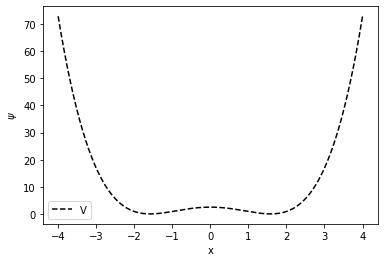

In [5]:
plt.plot(x,vx,'k--',label="V")
plt.xlabel("x")
plt.ylabel(r"$\psi$")
plt.legend()
plt.show()